In [2]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
from triqs.gf import *
from pydlr.kernel import kernel
from pydlr import dlr
import matplotlib.pyplot as plt
from dimer import *
from common import *

In [3]:
def constrained_lstsq_dlr_from_tau(dlr, 
                                   tau_i, 
                                   g_iaa, 
                                   beta,
                                   positivity=False, 
                                   discontinuity=False, 
                                   density=None,
                                   first_moment=None,
                                   second_moment=None,
                                   realvalued=False,
                                   ftol=1e-9, 
                                   symmetrizer=None):
    
    nx = len(dlr)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    # -- Real/Hermitian setup
    
    if realvalued:
        dtype = float
        g_iaa = np.array(g_iaa.real, dtype=dtype)
        nX = nx * (no + N)
        #merge_re_im = lambda x : x[:nx*no], x[nx*no:]
        def merge_re_im(x):
            return x[:nx*no], x[nx*no:]
        split_re_im = lambda x_d, x_u : np.concatenate((
            np.array(x_d.real, dtype=float), np.array(x_u.real, dtype=float)))
    else:
        dtype = complex
        nX = nx * (no + 2*N)

        def merge_re_im(x):
            x_d, x_u = x[:nx*no], x[nx*no:]
            re, im = np.split(x_u, 2)
            x_u = re + 1.j * im
            return x_d, x_u

        def split_re_im(x_d, x_u):
            return np.concatenate((
                np.array(x_d.real, dtype=float),
                np.array(x_u.real, dtype=float),
                np.array(x_u.imag, dtype=float)))
                                   
    # -- Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else  Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x

    # -- Setup constraints
    
    constraints = []

    if positivity:
        #for i in range(no):
        for i in sym.get_diag_indices():
            A_xaa = np.zeros(shape_xaa, dtype=dtype)
            A_xaa[:, i, i] = 1.
            A_nX = x_from_g(A_xaa)[None, :]

            #if np.max(A_nX) == 0: continue
            
            disc_constr = LinearConstraint(A_nX, -float('inf'), 0.)
            constraints.append(disc_constr)
        
    if discontinuity:
        for i in sym.get_diag_indices():
            A_xaa = np.zeros(shape_xaa, dtype=dtype)
            A_xaa[:, i, i] = 1.
            A_nX = x_from_g(A_xaa)[None, :]
            bound = -1.
            disc_constr = LinearConstraint(A_nX, bound, bound)
            constraints.append(disc_constr)

        for i, j in zip(*sym.get_triu_indices()):
            A_xaa = np.zeros(shape_xaa, dtype=dtype)
            A_xaa[:, i, j] = 1.
            A_nX = x_from_g(A_xaa)[None, :]            

            bound = 0.
            disc_constr = LinearConstraint(A_nX, bound, bound)
            constraints.append(disc_constr)
            if not realvalued:
                A_xaa[:, i, j] = 1.j
                A_nX = x_from_g(A_xaa)[None, :]
                bound = 0.
                disc_constr = LinearConstraint(A_nX, bound, bound)
                constraints.append(disc_constr)
                
    if density is not None:
        
        K_beta = -kernel(np.array([1.]), dlr.dlrrf)[0]
        
        I = np.eye(no*no)
        A_nX = np.einsum('x,AB->AxB', K_beta, I).reshape((no*no, nx*no*no))
        
        
        def mat_vec(mat):
            v_d = sym.get_x_d(mat[None, ...]).real
            v_u = sym.get_x_u(mat[None, ...])
            v = split_re_im(v_d, v_u)
            return v
            
        def density_constraint_function(x):
            g = g_from_x(x)
            mat = A_nX.dot(g.flatten()).reshape(no,no)
            vec = mat_vec(mat)
            return vec
            
        density_bound = mat_vec(density)
        density_constr = NonlinearConstraint(
            density_constraint_function, density_bound, density_bound)
        
        constraints.append(density_constr)
    
    if first_moment is not None:    
        dK_0_x, dK_beta_x = kernel(np.array([0., 1.]), dlr.dlrrf) * (-dlr.dlrrf[None, :]/beta)
        
        dK_x = dK_0_x + dK_beta_x
        I = np.eye(no*no)
        A_nX_1 = np.einsum('x,AB->AxB', dK_x, I).reshape((no*no, nx*no*no))
        
        def mat_vec(mat):
            v_d = sym.get_x_d(mat[None, ...]).real
            v_u = sym.get_x_u(mat[None, ...])
            v = split_re_im(v_d, v_u)
            return v
        
        def first_moment_constraint_func(x):
            g = g_from_x(x)
            mat = A_nX_1.dot(g.flatten()).reshape(no, no)
            vec = mat_vec(mat)
            return vec
        
        first_moment_bound = mat_vec(first_moment)
        
        constraints.append(NonlinearConstraint(first_moment_constraint_func,
                                           first_moment_bound, first_moment_bound))

    
    if second_moment is not None:    
        d2K_0_x, d2K_beta_x = kernel(np.array([0., 1.]), dlr.dlrrf) * (-dlr.dlrrf[None, :]/beta) * (-dlr.dlrrf[None, :]/beta)
        
        d2K_x = d2K_0_x + d2K_beta_x
        I = np.eye(no*no)
        A_nX_2 = np.einsum('x,AB->AxB', d2K_x, I).reshape((no*no, nx*no*no))
        
        def mat_vec(mat):
            v_d = sym.get_x_d(mat[None, ...]).real
            v_u = sym.get_x_u(mat[None, ...])
            v = split_re_im(v_d, v_u)
            return v
        
        def second_moment_constraint_func(x):
            g = g_from_x(x)
            mat = A_nX_2.dot(g.flatten()).reshape(no, no)
            vec = mat_vec(mat)
            return vec
        
        second_moment_bound = -mat_vec(second_moment)
    
        constraints.append(NonlinearConstraint(second_moment_constraint_func,
                                           second_moment_bound, second_moment_bound))
        

    def greens_function_difference(x):
        g_xaa = g_from_x(x)
        g_in_iaa = dlr.eval_dlr_tau(g_xaa, tau_i, beta) # straight up least squares
        err_iaa = g_in_iaa - g_iaa
        return err_iaa.flatten()
        
    def target_function(x):
        y = greens_function_difference(x)
        return np.linalg.norm(y)
    
    g0_xaa = dlr.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
    g0_laa = dlr.tau_from_dlr(g0_xaa)
    x0 = x_from_g(g0_xaa)
    
    sol = minimize(
        target_function, x0,
        method='SLSQP', constraints=constraints,
        options=dict(ftol=ftol),
        )

    sol.res = np.max(np.abs(greens_function_difference(sol.x)))
    sol.g_xaa = g_from_x(sol.x)
    sol.norm = -np.sum(sol.g_xaa, axis=0)
    sol.norm_res = np.max(np.abs(sol.norm - np.eye(no)))

    sol.density_res = float('nan')
    if density is not None: sol.density_res = np.max(np.abs(density_bound - density_constraint_function(sol.x)))

    return sol.g_xaa, sol


class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs


def unique_non_zero(arr):
    return [ i for i in np.unique(arr) if i != 0 ]


class BlockSymmetrizer:

    def __init__(self, nx, block_mat):

        assert(len(block_mat.shape) == 2)
        assert(block_mat.shape[0] == block_mat.shape[1])

        #print(f'block_mat =\n{block_mat}')
        
        no = block_mat.shape[0]
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        
        term_idxs = unique_non_zero(block_mat)
        #print(f'term_idxs = {term_idxs}')

        diag_idxs = np.arange(no)
        diag_terms = unique_non_zero(block_mat[diag_idxs, diag_idxs])
        #print(f'diag_terms = {diag_terms}')

        triu_idxs = np.triu_indices(no, k=+1)
        triu_terms = unique_non_zero(block_mat[triu_idxs[0], triu_idxs[1]])
        #print(f'triu_terms = {triu_terms}')

        diag_term_idxs = []
        for diag_term in diag_terms:
            idxs = []
            for i in range(no):
                if block_mat[i, i] == diag_term:
                    idxs.append(i)
            diag_term_idxs.append(idxs)
            #print(diag_term, idxs)

        #print(f'diag_term_idxs = {diag_term_idxs}')

        triu_term_idxs = []
        for triu_term in triu_terms:
            idxs = []
            for i, j in zip(triu_idxs[0], triu_idxs[1]):
                if block_mat[i, j] == triu_term:
                    idxs.append((i, j))
            triu_term_idxs.append(idxs)
            print(triu_term, idxs)

        #print(f'triu_term_idxs = {triu_term_idxs}')

        self.diag_term_idx = [ idxs[0] for idxs in diag_term_idxs ]
        self.triu_term_idx = list(zip(*[ idxs[0] for idxs in triu_term_idxs ]))

        triu_term_idxs = [ list(zip(*term)) for term in triu_term_idxs ]
        #print(f'triu_term_idxs = {triu_term_idxs}')
        
        self.diag_terms, self.diag_term_idxs = diag_terms, diag_term_idxs
        self.triu_terms, self.triu_term_idxs = triu_terms, triu_term_idxs

        #print(f'diag_term_idx = {self.diag_term_idx}')
        #print(f'triu_term_idx = {self.triu_term_idx}')

        if len(self.triu_term_idx) == 0:
            self.triu_term_idx = [[], []]

    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_term_idx, self.diag_term_idx].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        nx = g_xaa.shape[0]
        no = len(x_d) // nx
        for term_idx, diag_idxs in enumerate(self.diag_term_idxs):
            g_xaa[:, diag_idxs, diag_idxs] = x_d.reshape((nx, no))[:, term_idx][:, None]
        return g_xaa
        
    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_term_idx[0], self.triu_term_idx[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        for term_idx, triu_idxs in enumerate(self.triu_term_idxs):
            g_xaa[:, triu_idxs[0], triu_idxs[1]] = x_u.reshape((self.nx, self.N))[:, term_idx][:, None]

        g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa
        
    def get_diag_indices(self): return self.diag_term_idx
    def get_triu_indices(self): return self.triu_term_idx

In [4]:
def fit_dlr(dlr, G_tau, positivity=False, 
                        discontinuity=False, 
                        density=None,
                        first_moment=None,
                        second_moment=None):
    
    tau = np.array([x.real for x in G_tau.mesh])
    beta = G_tau.mesh.beta
    
    G_tau_fit = G_tau.copy()
    
    coefs = {}
    for block, gf in G_tau:
        
        coefs[block], _ = constrained_lstsq_dlr_from_tau(dlr, tau, G_tau[block].data, beta, 
                                                         positivity=positivity,
                                                         discontinuity=discontinuity,
                                                         density = density[block] if density else None,
                                                         first_moment = first_moment[block][2] if first_moment else None,
                                                         second_moment = second_moment[block][0] if second_moment else None,
                                                        )
        
        G_tau_fit[block].data[:] = dlr.eval_dlr_tau(coefs[block], tau, beta)
        
    return G_tau_fit, coefs

In [5]:
add_noise_tau = lambda noise : make_noisy_tau(G_tau_ref, noise)
Sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)
G_moments     = green_high_frequency_moments(dm, hdiag, gf_struct, h_imp)

In [6]:
for key in G_moments:
    G_moments[key][0] = Sigma_moments[key][-1] + G_moments[key][-1].dot(G_moments[key][-1]) + V_mat.dot(V_mat)

In [7]:
dm_matrix = {}

for name, bl_size in gf_struct:
    dm_matrix[name] = np.zeros((bl_size, bl_size), dtype=float)
    for a in range(bl_size):
        for b in range(bl_size):
            dm_matrix[name][a,b] = trace_rho_op(dm, c_dag(name, a)*c(name, b), hdiag)

In [8]:
G_tau_qmc = add_noise_tau(1e-4)
tau = np.array([float(x) for x in G_tau_qmc.mesh])
beta = G_tau_qmc.mesh.beta
iwn = np.array([complex(x) for x in G_iw_ref.mesh])

In [9]:
d = dlr(lamb=20, eps=1e-6)

In [10]:
G_tau_solutions = { 'None'    : fit_dlr(d, G_tau_qmc),
                '1'     : fit_dlr(d, G_tau_qmc, discontinuity=True),
               #'1_ρ'    : fit_dlr(d, G_tau_qmc, discontinuity=True, density=dm_matrix),
               '1_G0'   : fit_dlr(d, G_tau_qmc, discontinuity=True, first_moment=G_moments),
               #'1_ρ_G0' : fit_dlr(d, G_tau_qmc, discontinuity=True, first_moment=G_moments, density=dm_matrix),
               #'1_ρ_G0_G1' : fit_dlr(d, G_tau_qmc, discontinuity=True, first_moment=G_moments, second_moment=G_moments, density=dm_matrix),
                '1_G0_G1' : fit_dlr(d, G_tau_qmc, discontinuity=True, first_moment=G_moments, second_moment=G_moments)   
               }

In [11]:
def G_iw_from_x(coefs):
    G_iw_fit = G_iw_ref.copy()
    iwn = np.array([complex(w) for w in G_iw_ref.mesh])
    beta = G_iw_fit.mesh.beta
    for block, gf in G_iw_fit: G_iw_fit[block].data[:] = d.eval_dlr_freq(coefs[block], iwn, beta)
    return G_iw_fit

In [12]:
G_iw_solutions = {key : G_iw_from_x(val[1]) for key, val in G_tau_solutions.items()}

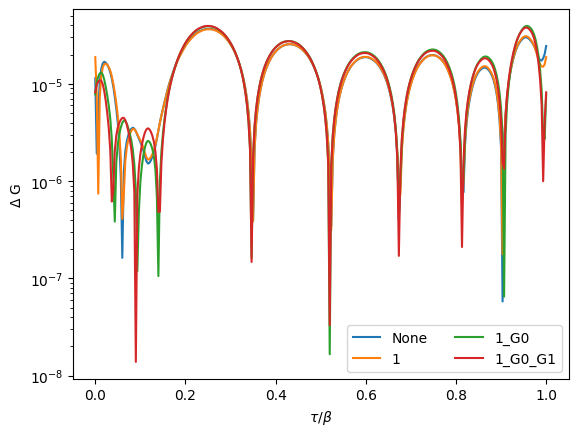

In [13]:
plt.figure()
for key in G_tau_solutions:
    solution = G_tau_solutions[key][0]
    plt.semilogy(tau/beta, np.abs(G_tau_ref['up'].data[:,0,0].real-solution['up'].data[:,0,0].real),
                 label=key)
plt.legend(ncol=2)
plt.ylabel(r'$\Delta$ G'); plt.xlabel(r'$\tau/\beta$')
plt.show()

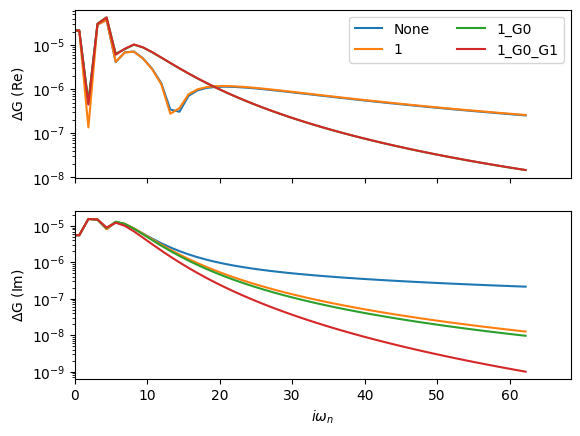

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)
for key in G_iw_solutions:
    solution = G_iw_solutions[key]
    ax[0].semilogy(iwn.imag, np.abs(G_iw_ref['up'].data[:,0,0].real-solution['up'].data[:,0,0].real),
                 label=key)
    ax[1].semilogy(iwn.imag, np.abs(G_iw_ref['up'].data[:,0,0].imag-solution['up'].data[:,0,0].imag))
ax[0].legend(ncol=2)
ax[0].set_ylabel(r'$\Delta$G (Re)'); ax[1].set_ylabel(r'$\Delta$G (Im)')
ax[1].set_xlabel(r'$i\omega_{n}$')
ax[0].set_xlim(0,)
plt.show()

In [15]:
Sigma_iw_solutions = {key: inverse(G0_iw) - inverse(val) for key, val in G_iw_solutions.items()}

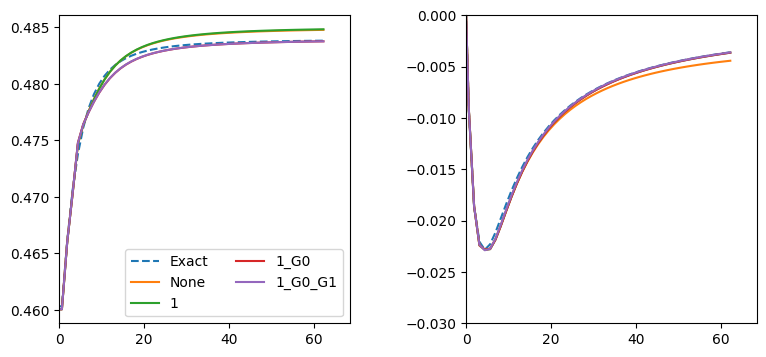

In [16]:
fig,ax = plt.subplots(1,2, figsize=(9,4))

ax[0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, '--', label='Exact')
ax[1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, '--')
for key, val in Sigma_iw_solutions.items():
    ax[0].plot(iwn.imag, val['up'].data[:,0,0].real,label=key, ms=4)
    ax[1].plot(iwn.imag, val['up'].data[:,0,0].imag, ms=4)
ax[0].legend(ncol=2)
ax[0].set_xlim(0,); ax[1].set_xlim(0,); ax[1].set_ylim(-0.03, 0)
plt.subplots_adjust(wspace=0.4)
plt.show()

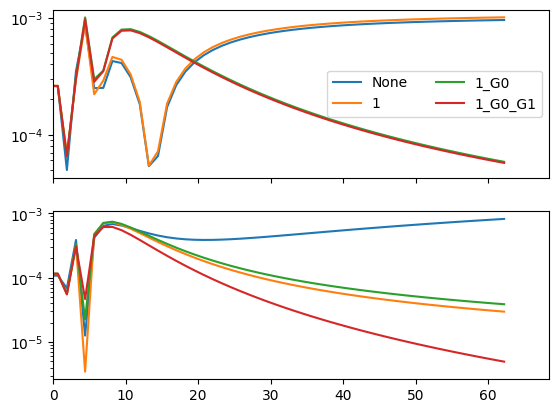

In [17]:
fig, ax = plt.subplots(2,1, sharex=True)
for key in Sigma_iw_solutions:
    solution = Sigma_iw_solutions[key]
    ax[0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-solution['up'].data[:,0,0].real),
                 label=key)
    ax[1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-solution['up'].data[:,0,0].imag))
ax[0].legend(ncol=2)
ax[0].set_xlim(0,)
plt.show()

In [18]:
print('{0:12s}  {1:12s}'.format('constr', 'ΔG'))
for key in G_tau_solutions:
    solution = G_tau_solutions[key][0]
    print('{0:12s}  {1:12.8e}'.format(key, np.max(np.abs(solution['up'].data[:,0,0].real-G_tau_ref['up'].data[:,0,0]))))

constr        ΔG          
None          3.68076786e-05
1             3.64688908e-05
1_G0          3.94221810e-05
1_G0_G1       3.94075298e-05


In [19]:
print('{0:12s}   {1:12s}   {2:12s}'.format('constr', 'ΔG (Re)', 'ΔG (Im)'))
for key in G_iw_solutions:
    solution = G_iw_solutions[key]
    print('{0:12s}   {1:12.8e}   {2:12.8e}'.format(key, 
                                      np.max(np.abs(solution['up'].data[:,0,0].real-G_iw_ref['up'].data[:,0,0].real)),
                                      np.max(np.abs(solution['up'].data[:,0,0].imag-G_iw_ref['up'].data[:,0,0].imag))))

constr         ΔG (Re)        ΔG (Im)     
None           3.67757314e-05   1.54860469e-05
1              3.69667309e-05   1.54584448e-05
1_G0           4.25626653e-05   1.53954285e-05
1_G0_G1        4.22475582e-05   1.54712231e-05


In [20]:
print('{0:12s}   {1:12s}   {2:12s}'.format('constr', 'ΔΣ (Re)', 'ΔΣ (Im)'))
for key in Sigma_iw_solutions:
    solution = Sigma_iw_solutions[key]
    print('{0:12s}   {1:12.8e}   {2:12.8e}'.format(key, 
                                      np.max(np.abs(solution['up'].data[:,0,0].real-Sigma_iw_ref['up'].data[:,0,0].real)),
                                      np.max(np.abs(solution['up'].data[:,0,0].imag-Sigma_iw_ref['up'].data[:,0,0].imag))))

constr         ΔΣ (Re)        ΔΣ (Im)     
None           9.56753079e-04   8.21796981e-04
1              1.00875448e-03   7.26605065e-04
1_G0           1.00625779e-03   7.44417688e-04
1_G0_G1        9.72226770e-04   6.16463163e-04
